

1. We are going to create and Essay writer.

2. This is going to be broken down into a frew different sub steps

3. First we are going to generate a plan - this going to happen once - upfront

4. Based on the plan we are going to some research

5. The research involves calling Tavily and getting back some documents

6. From there, we will go to generate

7. For generate, we follow the plan using the documents that we researched and we're going to write the essay

8. From there we finish or we are going to continue

9. If we are to continue, we go to the reflect node and we are going to generate a critique of the current essay

10. Based on the critique, we are going to do another research step with Tavily and get another set of documents

11. We will append those to the existing set of docuemnts and go all the way back to the generate step where we once again write the essay

12. We continue this until some criteria is met and we exit

13. Let us see this in code

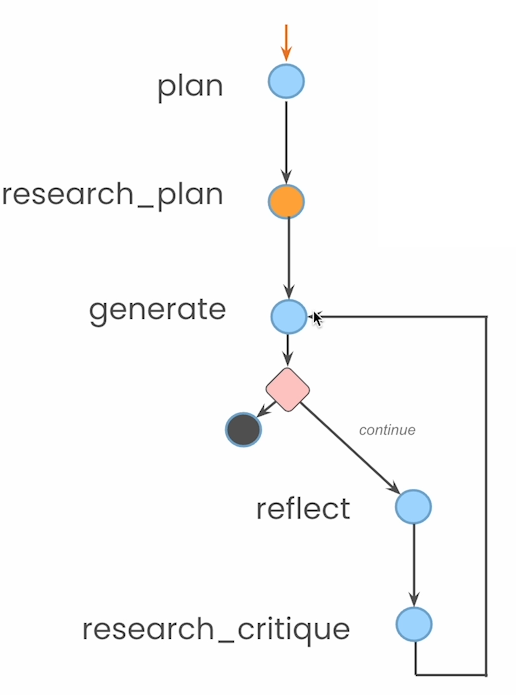






In [ ]:
# 1. We start by setting up the environment

import os
import openai
os.environ["OPENAI_API_KEY"] = ""
openai.api_key = os.environ['OPENAI_API_KEY']
os.environ["TAVILY_API_KEY"] = ""

In [ ]:
# 2. We make some standard imports and set up the in memory sqlite checkpointer
# 3. The imports pertain to the graph as in earlier notebooks

!pip install langgraph
!pip install langchain-openai
!pip install langchain-community
!pip install langgraph-checkpoint-sqlite

from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [ ]:
# 4. We will now create the AgentState
# 5. We are goint to keep track of a bunch of different things
# 6. Firstly, we have to keep track of the task
# 7. This is human input - this is what we are trying to write the essay about
# 8. Then we have a key to keep rack of the plan
# 9. This is the key which the planning Agent will generate
# 10. Then we have a key to keep track of the draft
# 11. This is the draft of the essat
# 12. We have a key o keep a track of the critique which the critique Agent
# will add in
# 13. We also ave to addd in the content. This is a key to keep a track of list
# of docuemnts that Tavily has researched and has come back with
# 14. We ahve two arguments to keep track of the iterations we have gone
# through this process
# 15. We ahve the revision numberwhich keep track of the number of revisions we
# made and we max revisions which is keeping tack of max revsions
# 16. The number of revsions and max revisions will be the criteria to stop or
# not


class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [ ]:
# 17. We now create the model
# 18 We are going to be using OpenAI

from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4.1", temperature=0)

In [ ]:
# 19. We are now ready to write some prompts for the Agents
# 20. We first have the Planning Prompt
# 21. This is the prompo for the LLM that is going to write out the plan

PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [ ]:
# 22. We next have the writer Prompt.
# 23. This is the one who is writing the essay given all the content that was
# researched.

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

In [ ]:
# 24. We then have the Reflection PRompt
# 25. This is the prompt that is going to control how we are critiquing the
# draft of the essay

REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [ ]:
# 26. We now have the prompt for the Agent who is doign the Research after the
# planning step
# 27. Given a plan we are going to generate a bunch of queries and pass
# this to tavily
# 28. This is the prompt that does that
## [ Put this After PLAN_PROMPT]
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [ ]:
# 29. We also have the Research Critique Prompt
# 30. That is after we have made the Critique we are going to generate the list
# of queries to pass to tavily
# 31. This is slightly different from the Planning Prompt because we are working
# on a  critique after the plan but serves similar purpose

RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [ ]:
# 32. For generating the list of queries to pass to Tavily, we are going to use
# function calling to ensure we get back a list of strings from the LAnguage
# model
# 33. In order to do that we are going to set up the pydantic model that
# represents the result we are going to get back from the LAnguage model
# which in this acse is a list of strings.

from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]


In [ ]:
# 34. We import the Tavily client

!pip install tavily-python
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [ ]:
# 35. We now start to create all our different Agents, all
# our different nodes
# 36. We will go in order
# 37. Start with Agent node that does the planning
# 38. What this node is going to do is that it si going to
# take in teh state and then its going to craete a list of messages
# 39. One of them is going to be the planning prompt which is going to be the
# System message
# 40. We are then going to create a human message that is the task we want to do
# 41. We'll pass that to the model and we're going to get back a message and
# we take the content oif the mssage and set it equal to plan
# 42. This will update the plan key to be the response

def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}


In [ ]:
# 43. The next node that we will do is the Agent that takes in the plan
# and does some research
# 44. For this, we craete the research plan node
# 45. This will take in the Agent state and we're first going to generate some
# queries
# 46. We are invoking the OpenAI model , we are going to say with structured
# out and put queries there
# 47. The response wer are going to invoke this is the pydantic object that we
# had which has the list of queries
# 48. We call invoke and we invoke on a list of messages
# 49. We have the research planning prompt and we pass in the human message the
# task
# 50. we get back the list of conten documents that we are going to
# use to write the essay
# 51. We are going to then take the list of queries we generated and then loop
# through the Tivily serach tool and get back the results and add to the content
# 52. It should be noted that we append the content if not empty
# 53. We are going to return the content key equal to the content which is the
# result of the original content plus the accumulated content

def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [ ]:
# 54. We made the plan and done some initial research.
# 55. It is now time to write the first draft
# 56. This is the generation ndoe - the first thing we do is prepare the
# content
# 57. As seen below, we take the list of strings and join them into a big one
# 58. We are then going to create the user message, where we coming the task
# and the plan as shown.
# 59. The plan was generated two steps before
# 60. The task is the original user input
# 61. We are then going to create a list of  messages - first we have the
# system message with the writer prompt where we format in this content,
# format the documents fetched and we then pass in the user message which is
# the combination of task and the plan.
# 62. We will pass this to the model and get back the response
# 63. We update two things in the state:
# a) First we update the draft. We take response from the model and update it
# b) We then update the revision number. This will keep track of how many
# revisions we have made.

def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }



In [ ]:
# 64) After generating, we now need the reflection node
# 65) The reflection node wll take the Reflection Prompt as the system prompt
# and we take the draft as the user message
# 66) We will pass these two messages into the model and get back a  response
# 67) This will generate a critique that we are going to update the state with

def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [ ]:
# 68) The last Agent we need is the Agent that will take the critique and
# do some reearch
# 69) We will do the same thing that we did with the Research Plan node
# 70) We are going to take tghe model , we're going to do stuctured output with
# query so that it returns the queries
# 71) We then invoke it
# 72) This time we pass the Research Critique Prompt as System message
# 73) And we also pass the critique from before as Human Message
# 74) Based on that we get the current content list
# 75) We then start appending to it the Tavily Searches
# 76) We return the updated content key


def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [ ]:
# 77) The final thing we need is the should_continue function
# 78) This looks at the revision number and if its greater than the max
# revisions, we are going to end
# 79) If not we go to the reflect node
# 80) It should be remembered that this getting run after the generation step
# 81) So, after the generation step, we either finish or go the critique loop

def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"


In [ ]:
# 82) Now: We made all our Agents/ all our nodes
# 83) We made our conditional edge
# 84) We put this togetehr into one Big GRaph
# 85) First, we initialize the Graph with the Agent Satte
builder = StateGraph(AgentState)


In [ ]:
# 82) We then add in all the nodes that were created

builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [ ]:
# 83) We then need to set an entry point
# 84) The entry point here will be the planning node
builder.set_entry_point("planner")

In [ ]:
# 85) We then add the conditional edge
# 86) After generate, we call the should_continue function
# 87) We decide to end or to reflect
# 88) If the should_continue function returns end- we end
# 89) IF it returns reflect, we go to teh reflect node

builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

In [ ]:
# 90) We then add the basic edges
# 91) The Edges reflect how we traverse through the nodes
# 92) After Planning we go to the research plan
# 93) From Research Plan we go to the generate node
# 94) generate is already covered in the should_continue
# 95) After reflect we go to reserch_critique
# 96) From research critique we go to the generate node

builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [ ]:
# 97) We now compile the graph and we pass in the check pointer created before.

graph = builder.compile(checkpointer=memory)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


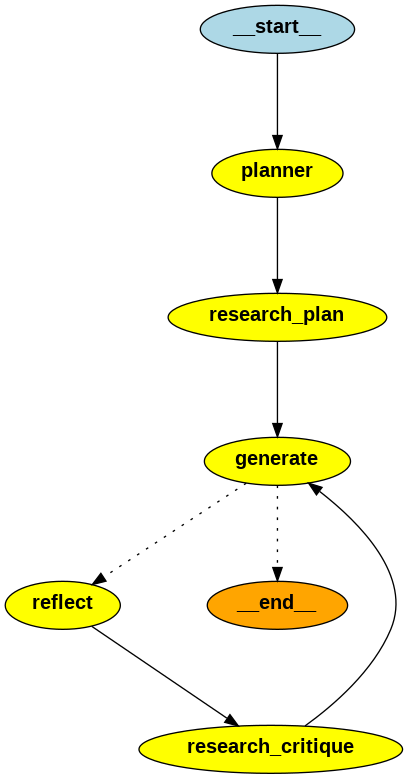

In [ ]:
# 98) We can visualize the Graph
# 99) Its a much more complex Graph
# Step 1: Install system dependencies
!apt-get install -y graphviz graphviz-dev

# Step 2: Install pygraphviz via pip
!pip install pygraphviz


from IPython.display import Image

Image(graph.get_graph().draw_png())


In [ ]:
# 100) Now, lets use the Writing Agent
# 101) We call graph.stream so that w ecan see all the steps that are happening
# 102) TThis will take a while
# 103) Lets pass ina  task
# 104) Lets ask "Tell us about career journey of Ajay Taneja of JLR?"
# 105) WE pass max_revisons = 2 and we pass in revision_number equals 1
#106) Lets call the below snippet and see it working

from langgraph.checkpoint.sqlite import SqliteSaver
from contextlib import contextmanager

# Step 1: Manually enter the context manager to get the actual SqliteSaver object
memory_cm = SqliteSaver.from_conn_string(":memory:")
memory = memory_cm.__enter__()  # unwrap the context manager

# Step 2: Compile your graph with the actual checkpointer
# Assuming you already have a graph builder:
# builder = StateGraph(...)
# builder.add_node(...) etc.
graph = builder.compile(checkpointer=memory)

# Step 3: Stream execution
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    "task": "Tell us about career journey of Ajay Taneja of JLR",
    "max_revisions": 2,
    "revision_number": 1,
     "content": []
}, thread):
    print(s)

# Step 4: Clean up
memory_cm.__exit__(None, None, None)




{'planner': {'plan': '**High-Level Essay Outline: The Career Journey of Ajay Taneja of JLR**\n\n---\n\n**I. Introduction**  \n- Brief overview of Ajay Taneja and his current role at Jaguar Land Rover (JLR)  \n- Importance of his contributions to the automotive industry  \n- Purpose and scope of the essay\n\n**II. Early Life and Educational Background**  \n- Summary of Ajay Taneja’s early life and formative influences  \n- Educational qualifications (degrees, institutions, specializations)  \n- How his education shaped his career trajectory\n\n**III. Early Career and Professional Foundations**  \n- First roles in the automotive or related industries  \n- Key skills and experiences gained in early positions  \n- Notable achievements or projects during this period\n\n**IV. Joining Jaguar Land Rover (JLR)**  \n- Circumstances and motivations for joining JLR  \n- Initial role and responsibilities at JLR  \n- Early challenges and how he addressed them\n\n**V. Career Progression within JLR** 

/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1914: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_plan': {'content': ['Ajay Taneja, based in Gaydon, GB, is currently a Generative AI Engineer at JLR. Ajay Taneja brings experience from previous roles at Jaguar Land Rover.', 'An Ajay Taneja who is the Director of Finance and Commercial at INDORAMA in Senegal.2; Another Ajay Taneja who is a Senior Data Engineer at Jaguar Land Rover.', 'Ajay Taneja, based in Gaydon, GB, is currently a Generative AI Engineer at JLR. Ajay Taneja brings experience from previous roles at Jaguar Land Rover.', 'Missing: professional JLR', 'Ajay Taneja, based in Gaydon, GB, is currently a Generative AI Engineer at JLR. Ajay Taneja brings experience from previous roles at Jaguar Land Rover.', 'An Ajay Taneja who is the Director of Finance and Commercial at INDORAMA in Senegal. 2. Another Ajay Taneja who is a Senior Data Engineer at Jaguar Land Rover.']}}
{'generate': {'draft': '**The Career Journey of Ajay Taneja of JLR**\n\nAjay Taneja stands as a prominent figure in the automotive industry, current

/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1914: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


{'research_critique': {'content': ['Ajay Taneja, based in Gaydon, GB, is currently a Generative AI Engineer at JLR. Ajay Taneja brings experience from previous roles at Jaguar Land Rover.', 'An Ajay Taneja who is the Director of Finance and Commercial at INDORAMA in Senegal.2; Another Ajay Taneja who is a Senior Data Engineer at Jaguar Land Rover.', 'Ajay Taneja, based in Gaydon, GB, is currently a Generative AI Engineer at JLR. Ajay Taneja brings experience from previous roles at Jaguar Land Rover.', 'Missing: professional JLR', 'Ajay Taneja, based in Gaydon, GB, is currently a Generative AI Engineer at JLR. Ajay Taneja brings experience from previous roles at Jaguar Land Rover.', 'An Ajay Taneja who is the Director of Finance and Commercial at INDORAMA in Senegal. 2. Another Ajay Taneja who is a Senior Data Engineer at Jaguar Land Rover.', 'This is where it all begins to get real! "Deploying Machine Learning Models in Production" A great start of the final course in the MLOps', "Ajay

False

In [ ]:
# 107) We can see we have a plan first
# 108) Then there is some research
# 109) Then we get back a bunch of dosuments
# 110) We get a first draft
# 111) We can see it generated a title and essay
# 112) IT starts writing
# 113) We can also see the critiquing that the Agent did
# 114) Recommendations
# 115) Research critique node
# 116) Second draft